<a href="https://colab.research.google.com/github/nev12/gym-dropout-prediction/blob/main/00_data_sanity_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Gym Member Dropout and Training Patterns Using Longitudinal Check-in Data

## Understanding the Data

This notebook performs an initaial sanity check of the raw gym data to understand schema, validate data ranges, and identify potential data quality issues before feature engineering.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np

### 1. Loading the data

Loading the data of all 4 files, and getting a first look at them.

In [2]:
from google.colab import files

uploaded = files.upload()

Saving checkin_checkout_history_updated.csv to checkin_checkout_history_updated.csv
Saving gym_locations_data.csv to gym_locations_data.csv
Saving subscription_plans.csv to subscription_plans.csv
Saving users_data.csv to users_data.csv


In [3]:
dfs = {}
for filename in uploaded.keys():
  dfs[filename] = pd.read_csv(filename)

In [4]:
users = dfs['users_data.csv']

print("USERS DATA:")
print("rows: ", users.shape[0])
print("columns: ", users.shape[1])

users.head()

USERS DATA:
rows:  5000
columns:  9


,user_id,first_name,last_name,age,gender,birthdate,sign_up_date,user_location,subscription_plan
0,user_1,Chris,Wilson,56,Female,2000-02-29,2023-02-06,Denver,Basic
1,user_2,Michael,Miller,46,Non-binary,1978-12-22,2023-08-08,Orlando,Pro
2,user_3,Daniel,Smith,32,Female,1962-08-30,2021-01-11,Orlando,Basic
3,user_4,David,Smith,60,Male,2003-12-05,2023-08-07,Denver,Pro
4,user_5,Chris,Jones,25,Female,2004-08-25,2021-01-08,Denver,Basic


In [5]:
checkins = dfs['checkin_checkout_history_updated.csv']

print("CHECKIN CHECKOUT HISTORY UPDATED:")
print("rows: ", checkins.shape[0])
print("columns: ", checkins.shape[1])

checkins.head()

CHECKIN CHECKOUT HISTORY UPDATED:
rows:  300000
columns:  6


,user_id,gym_id,checkin_time,checkout_time,workout_type,calories_burned
0,user_3291,gym_6,2023-09-10 15:55:00,2023-09-10 16:34:00,Weightlifting,462
1,user_1944,gym_2,2023-04-13 20:07:00,2023-04-13 22:43:00,Yoga,1278
2,user_958,gym_7,2023-06-10 12:24:00,2023-06-10 13:49:00,Cardio,858
3,user_811,gym_2,2023-05-23 17:11:00,2023-05-23 20:01:00,Yoga,1134
4,user_4923,gym_10,2023-02-21 06:20:00,2023-02-21 08:02:00,Weightlifting,1049


In [6]:
substriptions = dfs['subscription_plans.csv']

print("SUBSCRIPTION PLAN:")
print("rows: ", substriptions.shape[0])
print("columns: ", substriptions.shape[1])

substriptions.head()

SUBSCRIPTION PLAN:
rows:  3
columns:  3


,subscription_plan,price_per_month,features
0,Basic,19.99,"Access to basic gym facilities, Limited class ..."
1,Pro,49.99,"Access to all facilities, Unlimited class acce..."
2,Student,9.99,"Access to basic facilities, Limited class acce..."


In [7]:
gyms = dfs['gym_locations_data.csv']

print("GYM LOCATIONS DATA:")
print("rows: ", gyms.shape[0])
print("columns: ", gyms.shape[1])

gyms.head()

GYM LOCATIONS DATA:
rows:  10
columns:  4


,gym_id,location,gym_type,facilities
0,gym_1,New York,Premium,"Climbing Wall, Swimming Pool, Basketball Court"
1,gym_2,Los Angeles,Budget,"Climbing Wall, Yoga Classes, Sauna"
2,gym_3,Chicago,Budget,"Sauna, Climbing Wall, Swimming Pool"
3,gym_4,Houston,Premium,"Climbing Wall, Basketball Court, Swimming Pool"
4,gym_5,Phoenix,Standard,"Basketball Court, CrossFit, Swimming Pool"


### 2. Primary  keys and joins:

- Since user_id appears across users and check-in tabels, it will be used as the primary join key between them.

- While between users and subscriptions that will be subscription_plan, and for check-in and gyms will be gym_id


### 3. Checking data types and null (missing) values:


In [8]:
print("USERS DATA:\n")

for col in users.columns:
  print(col, users[col].dtype)
  null_sum = users[col].isna().sum()
  print(col, " null values: ", null_sum)

USERS DATA:

user_id object
user_id  null values:  0
first_name object
first_name  null values:  0
last_name object
last_name  null values:  0
age int64
age  null values:  0
gender object
gender  null values:  0
birthdate object
birthdate  null values:  0
sign_up_date object
sign_up_date  null values:  0
user_location object
user_location  null values:  0
subscription_plan object
subscription_plan  null values:  0


In [9]:
print("CHECK-IN DATA:\n")

for col in checkins.columns:
  print(col, checkins[col].dtype)
  null_sum = checkins[col].isna().sum()
  print(col, " null values: ", null_sum)

CHECK-IN DATA:

user_id object
user_id  null values:  0
gym_id object
gym_id  null values:  0
checkin_time object
checkin_time  null values:  0
checkout_time object
checkout_time  null values:  0
workout_type object
workout_type  null values:  0
calories_burned int64
calories_burned  null values:  0


In [10]:
print("SUBSCRIPTIONS DATA:\n")

for col in substriptions.columns:
  print(col, substriptions[col].dtype)
  null_sum = substriptions[col].isna().sum()
  print(col, " null values: ", null_sum)

SUBSCRIPTIONS DATA:

subscription_plan object
subscription_plan  null values:  0
price_per_month float64
price_per_month  null values:  0
features object
features  null values:  0


In [11]:
print("GYM LOCATIONS DATA:\n")

for col in gyms.columns:
  print(col, gyms[col].dtype)
  null_sum = gyms[col].isna().sum()
  print(col, " null values: ", null_sum)

GYM LOCATIONS DATA:

gym_id object
gym_id  null values:  0
location object
location  null values:  0
gym_type object
gym_type  null values:  0
facilities object
facilities  null values:  0


### 4. Checking date ranges:

Since the all the date and time columns in both users and check-in tables are type object, they will first need to converted.

In [12]:
users['birthdate'] = pd.to_datetime(users['birthdate'])
users['sign_up_date'] = pd.to_datetime(users['sign_up_date'])

checkins['checkin_time'] = pd.to_datetime(checkins['checkin_time'])
checkins['checkout_time'] = pd.to_datetime(checkins['checkout_time'])

In [13]:
print("youngest gym user is born on: ", users['birthdate'].max(), " and in 2023 was: ", 2023-users['birthdate'].max().year)
print("olderst gym user is born on: ", users['birthdate'].min(), " and in 2023 was: ", 2023-users['birthdate'].min().year)

print("first person signed up for a gym on: ", users['sign_up_date'].min())
print("last person signed up for a gym on: ", users['sign_up_date'].max())

print("first checkin was detected in: ", checkins['checkin_time'].min())
print("last checkin was detected in: ", checkins['checkin_time'].max())

youngest gym user is born on:  2005-12-28 00:00:00  and in 2023 was:  18
olderst gym user is born on:  1958-01-04 00:00:00  and in 2023 was:  65
first person signed up for a gym on:  2021-01-01 00:00:00
last person signed up for a gym on:  2023-10-15 00:00:00
first checkin was detected in:  2023-01-01 06:00:00
last checkin was detected in:  2023-10-15 20:59:00


- Even though there are users that signed up a long time ago, checkin data is only from january 1st 2023 - untill october 15th 2023

<Axes: xlabel='checkin_time'>

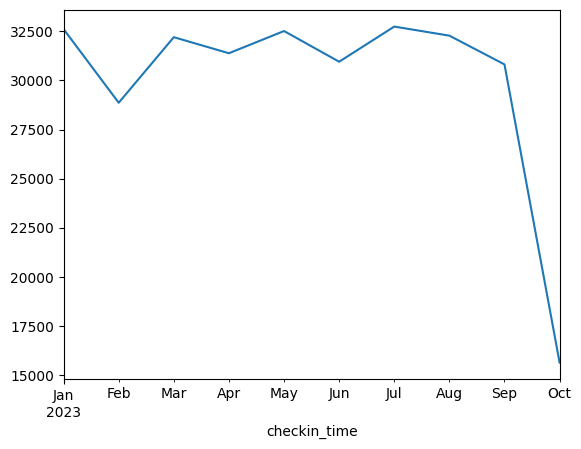

In [14]:
checkins['checkin_time'].dt.to_period('M').value_counts().sort_index().plot()

<Axes: xlabel='sign_up_date'>

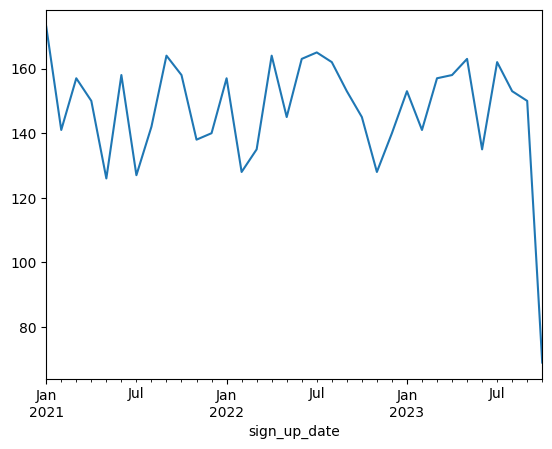

In [15]:
users['sign_up_date'].dt.to_period('M').value_counts().sort_index().plot()

In [16]:
merged = checkins.merge(
    users[['user_id', 'sign_up_date']],
    on = 'user_id',
    how = 'left'
)

incorrect = merged[merged['checkin_time'] < merged['sign_up_date']]
print(incorrect[['user_id', 'sign_up_date', 'checkin_time']])

          user_id sign_up_date        checkin_time
1       user_1944   2023-07-16 2023-04-13 20:07:00
13      user_4489   2023-09-27 2023-04-06 17:32:00
17      user_4922   2023-07-04 2023-05-29 16:01:00
26      user_2242   2023-03-09 2023-01-16 07:34:00
30      user_2853   2023-05-19 2023-05-01 18:52:00
...           ...          ...                 ...
299974  user_2471   2023-07-18 2023-03-11 09:25:00
299977  user_3477   2023-08-05 2023-02-03 12:33:00
299982  user_4590   2023-03-22 2023-01-17 09:58:00
299989  user_1228   2023-08-21 2023-04-05 12:21:00
299999  user_3314   2023-08-27 2023-01-05 08:58:00

[42932 rows x 3 columns]


In [17]:
user_num = incorrect['user_id'].nunique()
print("The number of users with checkin dates before the signup date is: ", user_num)

The number of users with checkin dates before the signup date is:  1416


- This shows that there are 1416 users with check-ins dated before the sign up dates.

- This data is flagged and will be handeled separately!

### 5. Seeing if there is a user with no checkins:

In [19]:
users_without_checkins = (
    set(users['user_id']) - set(checkins['user_id'])
)

print("there are ", len(users_without_checkins), " that have no checkins")

there are  0  that have no checkins
